# Phase II Project Technical Notebook

Authors: Kyle Dufrane and Kevin McDonough

In [1]:
# Imports 
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
%load_ext autotime
from folium.plugins import StripePattern
import geopandas as gpd

time: 571 ms (started: 2021-06-03 17:15:40 -08:00)


## Business Understanding 

Our stakeholder is a family that is moving to the Seattle area. They would like to buy a house that maximizes square footage, and they are looking for a house that they deem to be under-valued. There are 3 children in the family, so they would like to find a house with at least 4 bedrooms. 

## Data Understanding

In [2]:
df = pd.read_csv('data/KC_with_hoods', index_col=0)

time: 52.6 ms (started: 2021-06-03 17:15:41 -08:00)


In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Neighborhood
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,Rainier Beach
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,Northgate
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,Kenmore
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,Fauntleroy
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammamish


time: 25 ms (started: 2021-06-03 17:15:41 -08:00)


This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. In the datframe above, we used an API that allowed us to reverse geocode the latitude and longitude into neighborhoods. The code for this can be found in our individual technical notebooks -- it is a lot of code so we thought we'd leave it out of this notebook. The process of reverse geocoding all 21,597 entries in our DataFrame took ~5 hours. Below is a description of what head column represents: 

**id** - unique identifier for a house  <br>
**date** - house was sold  <br>
**price** -  is prediction target  <br>
**bedrooms** -  of Bedrooms/House  <br>
**bathrooms** -  of bathrooms/bedrooms  <br>
**sqft_living** -  footage of the home  <br>
**sqft_lot** -  footage of the lot  <br>
**floors** -  floors (levels) in house  <br>
**waterfront** - House which has a view to a waterfront  <br>
**view** - Has been viewed  <br>
**condition** - How good the condition is ( Overall )  <br>
**grade** - overall grade given to the housing unit, based on King County grading system  <br>
**sqft_above** - square footage of house apart from basement  <br>
**sqft_basement** - square footage of the basement  <br>
**yr_built** - Built Year  <br>
**yr_renovated** - Year when house was renovated  <br>
**zipcode** - zip  <br>
**lat** - Latitude coordinate  <br>
**long** - Longitude coordinate  <br>
**sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors  <br>
**sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors  <br>
**Neighborhood** - geopy reverse geocoded neighborhoods using the lat and long columns

## Data Cleaning 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Inspecting this, we can see that "date" and "sqft_basement" are currently objects, so we will have to convert them to usable formats before we model. Let's start by converting date two two new categories month and year:

In [5]:
df['Yr_sold'] = df['date'].apply(lambda x: x[-4:])
df['Mo_sold'] = df['date'].apply(lambda x: x[0:2])
df['Mo_sold'] = df['Mo_sold'].apply(lambda x: x[0:1] if "/" in x else x)

time: 18.8 ms (started: 2021-06-03 17:15:41 -08:00)


In [6]:
df['Mo_sold'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: Mo_sold, dtype: int64

time: 5.26 ms (started: 2021-06-03 17:15:41 -08:00)


Looks like the least number of homes were sold in January. Because this is a categorical variable, we will have to create dummies to incorporate this into the model. Knowing that January has the least number of values, that could be a good column to drop.

In [7]:
df['Yr_sold'].value_counts()

2014    14622
2015     6975
Name: Yr_sold, dtype: int64

time: 5.71 ms (started: 2021-06-03 17:15:41 -08:00)


This dataset only spans 2014 to 2015 so it makes sense that these are the two values. Because there are only two values, we can use OrdinalEncoder to turn this into a binary variable.

In [8]:
from sklearn.preprocessing import OrdinalEncoder
year = df[['Yr_sold']]
encoder_year = OrdinalEncoder()
encoder_year.fit(year)
year_encoded = encoder_year.transform(year)
year_encoded = year_encoded.flatten()
df['Yr_sold'] = year_encoded

time: 9.55 ms (started: 2021-06-03 17:15:41 -08:00)


Now that we have transformed the dates, we can drop the original date column 

In [9]:
df = df.drop('date', axis=1)

time: 5.48 ms (started: 2021-06-03 17:15:41 -08:00)


Now let's check out why the sqft_basement category was an object rather than an integer or float

In [10]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
652.0         1
176.0         1
143.0         1
906.0         1
1920.0        1
Name: sqft_basement, Length: 304, dtype: int64

time: 5.64 ms (started: 2021-06-03 17:15:41 -08:00)


Looks like there is a "?" for missing values. This doesn't mean that there is no basement because there are 12,826 entries that have 0 for basement square footage. Let's substitute the median square footage in for all entries with a "?" (the median will be 0). 

In [11]:
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: np.nan if "?" in x else x)

time: 4.4 ms (started: 2021-06-03 17:15:41 -08:00)


In [12]:
basement = df[['sqft_basement']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(basement)
basement_imputed = imputer.transform(basement)
basement_imputed
df['sqft_basement'] = basement_imputed

time: 45.8 ms (started: 2021-06-03 17:15:41 -08:00)


In [13]:
df.isna().sum()

id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
Neighborhood        0
Yr_sold             0
Mo_sold             0
dtype: int64

time: 5.75 ms (started: 2021-06-03 17:15:41 -08:00)


Looks like the waterfront, view and yr_renovated columns are missing data, we will have to address this if we want to use these variables in our model. Let's start by checking out waterfront:

In [14]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

time: 3.79 ms (started: 2021-06-03 17:15:41 -08:00)


Looks like it is a binary variable that contains a 1 if the property is on the waterfront and 0 if it is not. We believe the best strategy is to replace the missing values with the median(0). 

In [15]:
waterfront = df[['waterfront']]
imputer = SimpleImputer(strategy='median')
imputer.fit(waterfront)
waterfront_imputed = imputer.transform(waterfront)
df['waterfront'] = waterfront_imputed

time: 9.16 ms (started: 2021-06-03 17:15:41 -08:00)


Now that we have cleaned up waterfront let's examine the view column

In [16]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

time: 4.38 ms (started: 2021-06-03 17:15:41 -08:00)


The view column tells us whether a property has been viewed. The numbers here must represent the amount of times it's been viewed. It looks like the vast majority have not been viewed so, once again, we will replace the missing values with the median (0).

In [17]:
view = df[['view']]
imputer = SimpleImputer(strategy='median')
imputer.fit(view)
view_imputed = imputer.transform(view)
df['view'] = view_imputed

time: 7.4 ms (started: 2021-06-03 17:15:41 -08:00)


In [18]:
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.264306
view             0.393497
condition        0.036056
grade            0.667951
sqft_above       0.605368
sqft_basement    0.321108
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Yr_sold          0.003727
Name: price, dtype: float64

time: 25.4 ms (started: 2021-06-03 17:15:41 -08:00)


In [19]:
df['view'].value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

time: 3.48 ms (started: 2021-06-03 17:15:41 -08:00)


The last column containing missing values is the Yr_renovated column, let's take a look: 

In [20]:
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

time: 3.9 ms (started: 2021-06-03 17:15:41 -08:00)


It appears that a value of 0 in this column signifies that the home has not been renovated. It is unclear whether the missing values mean that the home has not been renovated. To deal with this, let's use a function to bin the values. 

In [21]:
def bin_year(value):
    if value == 0:
        return "No remodel"
    elif value > 0 and value < 1980:
        return "pre-1980"
    elif value >= 1980 and value < 1990:
        return "1980s"
    elif value >= 1990 and value < 2000:
        return "1990s"
    elif value >= 2000 and value < 2010:
        return "2000s"
    elif value >= 2010 and value <= 2015:
        return "2010s"
    else:
        return "Unknown"

time: 421 µs (started: 2021-06-03 17:15:41 -08:00)


In [22]:
bin_year(2011)

'2010s'

time: 1.47 ms (started: 2021-06-03 17:15:41 -08:00)


In [23]:
df['yr_renovated'] = df['yr_renovated'].apply(bin_year)

time: 5.9 ms (started: 2021-06-03 17:15:41 -08:00)


In [24]:
df['yr_renovated'].value_counts()

No remodel    17011
Unknown        3842
2000s           229
2010s           150
1990s           143
1980s           124
pre-1980         98
Name: yr_renovated, dtype: int64

time: 4.93 ms (started: 2021-06-03 17:15:41 -08:00)


Because the variable is binned, we can create a dummies later if we want to incorporate it into our model. We have now dealt with all missing values and transformed the datatypes that were classified incorrectly so we can begin modeling 

## Business Understanding 

Our stakeholder is interested in purchasing a house at a reasonable cost. In order to aid them in this endeavor, we need to build a model that can accurately predict price. Additionally, we need to identify which features influence price the most. Lastly, we need to quantify the impact each feature has so that they can determine whether or not it is worth paying for. 

### Identifying Extraneous Features

Let's start by identifying which variables have the least impact on price. 

In [25]:
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.264306
view             0.393497
condition        0.036056
grade            0.667951
sqft_above       0.605368
sqft_basement    0.321108
yr_built         0.053953
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Yr_sold          0.003727
Name: price, dtype: float64

time: 22.5 ms (started: 2021-06-03 17:15:41 -08:00)


The id column is just the identifier used for each house so we should drop that for modeling purposes. we will also drop latitude and longitude -- we will create dummies for neighborhood and zipcode later that will do a better job of quantifying the effect location has on price than latitude and longitude do. 

In [26]:
relevant_cols = ['price', 'bedrooms','bathrooms','sqft_living','sqft_lot'\
                 ,'floors','waterfront','view','condition','grade','sqft_above', 'sqft_basement',\
                 'yr_built','yr_renovated','zipcode','sqft_living15','sqft_lot15','Neighborhood', 'Yr_sold', 'Mo_sold']

time: 373 µs (started: 2021-06-03 17:15:41 -08:00)


In [27]:
df = df[relevant_cols]

time: 4.67 ms (started: 2021-06-03 17:15:41 -08:00)


### First Simple Model

For our first simple model lets use square feet to predict price. We are choosing square feet because, based on the correlation output, it is the variable with the largest impact on price. Additionally, our stakeholder indicated they would like to have a house with high square-footage

In [28]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Neighborhood,Yr_sold,Mo_sold
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,No remodel,98178,1340,5650,Rainier Beach,0.0,10
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1990s,98125,1690,7639,Northgate,0.0,12
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,Unknown,98028,2720,8062,Kenmore,1.0,2
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,No remodel,98136,1360,5000,Fauntleroy,0.0,12
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,No remodel,98074,1800,7503,Sammamish,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,No remodel,98103,1530,1509,Licton Springs,0.0,5
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,No remodel,98146,1830,7200,White Center,1.0,2
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,No remodel,98144,1020,2007,Leschi,0.0,6
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,No remodel,98027,1410,1287,Issaquah,1.0,1


time: 31.4 ms (started: 2021-06-03 17:15:42 -08:00)


In [29]:
formula = 'price ~ sqft_living'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:15:42   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

time: 29.1 ms (started: 2021-06-03 17:15:42 -08:00)


Although the model doesn't do a great job of explaining the variance (r-squared = .493), the t value and associated p value tell us that sqft_living definitely impacts price. The coefficient tells us that every increase in square footage increases price by ~280. Now the stakeholder can roughly estimate the cost of an increase in square footage

### Multiple Regression Model

Next let's construct a multiple regression model to evaluate which columns to keep and get rid of. In order to do this, we need to create a df that doesn't contain any columns with categoricals (we will turn those into dummies later.)

In [30]:
categoricals = ['yr_renovated', 'zipcode', 'Neighborhood', 'Mo_sold']
df_no_cats = df.drop(categoricals, axis=1)

time: 3.13 ms (started: 2021-06-03 17:15:42 -08:00)


In [31]:
multiple_formula = 'price ~' + '+'.join(df_no_cats.columns[1:])
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2736.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:15:42   Log-Likelihood:            -2.9589e+05
No. Observations:               21597   AIC:                         5.918e+05
Df Residuals:                   21581   BIC:                         5.919e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.334e+06   1.31e+05     48.427      0.000    6.08e+06    6.59e+06
bedrooms      -3.984e+04   2031.935    -19.605      0.000   -4.38e+04   -3.59e+04
bathrooms      4.765e+04   3471.383     13.727      0.000    4.08e+04    5.45e+04
sqft_living     112.9512     19.369      5.832      0.000      74.987     150.915
sqft_lot         -0.0073      0.051     -0.143      0.886      -0.108       0.093
floors         2.806e+04   3782.065      7.420      0.000    2.06e+04    3.55e+04
waterfront     6.167e+05   1.94e+04     31.754      0.000    5.79e+05    6.55e+05
view           4.357e+04   2249.579     19.368      0.000    3.92e+04     4.8e+04
condition      2.001e+04   2463.351      8.123      0.000    1.52e+04    2.48e+04
grade          1.212e+05   2253.765     53.775      0.000    1.17e+05    1.26e+05
sqft_above       47.5625     19.340      2.459      0.014       9.655      85.471
sqft_basement    54.8696     19.194      2.859      0.004      17.248      92.491
yr_built      -3652.0764     67.274    -54.287      0.000   -3783.938   -3520.215
sqft_living15    24.2326      3.596      6.740      0.000      17.185      31.280
sqft_lot15       -0.5526      0.078     -7.057      0.000      -0.706      -0.399
Yr_sold         2.68e+04   3146.916      8.517      0.000    2.06e+04     3.3e+04
==============================================================================
Omnibus:                    16333.506   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1192294.244
Skew:                           3.035   Prob(JB):                         0.00
Kurtosis:                      38.890   Cond. No.                     4.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

time: 68.8 ms (started: 2021-06-03 17:15:42 -08:00)


This model does a much better job of explaining the variance. Also, the sqft_lot P value is very high so we will get rid of that variable moving forward. Let's next look at multicollinearity to identify if this is an issue:

In [32]:
correlation_matrix = df_no_cats.corr()

time: 12.8 ms (started: 2021-06-03 17:15:42 -08:00)


In [33]:
df_corr=correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(10)

,cc
pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758
"(sqft_living15, sqft_above)",0.731767
"(sqft_lot15, sqft_lot)",0.718204
"(grade, sqft_living15)",0.713867
"(price, sqft_living)",0.701917


time: 22.4 ms (started: 2021-06-03 17:15:42 -08:00)


square footage above is very correlated with total square footage. Because square footage above has a higher p-value in the summary above, as well as a lower overall correlation with price, we will remove this column going forward. 

In [34]:
df = df.drop('sqft_lot', axis=1)
df = df.drop('sqft_above', axis=1)

time: 6.17 ms (started: 2021-06-03 17:15:42 -08:00)


We should also quickly check to the see if the variables in the multiple model approximate a normal distribution

In [35]:
# for column in df_no_cats:
#     df_no_cats[column].plot.hist(density=True, label = column+' histogram')
#     df_no_cats[column].plot.kde(label =column+' kde')
#     plt.legend()
#     plt.show()

time: 213 µs (started: 2021-06-03 17:15:42 -08:00)


Besides the variables that are binary or discreet, it looks like they are fairly normally distributed and don't need major transformations

#### Feature Transformation

Next, let's see if any of the interactions between variables is a good predictor of price

In [36]:
pf = PolynomialFeatures(degree=2)

X = df_no_cats


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
corr_df[corr_df['x0'] > .75]['x0']

x0        1.000000
x0^2      0.839331
x0 x1     0.937872
x0 x2     0.917409
x0 x3     0.900728
x0 x5     0.908166
x0 x8     0.945235
x0 x9     0.982774
x0 x10    0.890669
x0 x12    0.999584
x0 x13    0.938750
x3 x9     0.756248
Name: x0, dtype: float64

time: 886 ms (started: 2021-06-03 17:15:42 -08:00)


Unsurprisingly the interactions that have the highest correlation with price ('x0') are mostly price multiplied by a different category. However, x3 * x9 has a high correlation with price as well. Examining pdf, we can see that this is square footage multiplied by grade. We should add this interaction into our model to see the effect on r-squared

In [37]:
df_no_cats = df.drop(categoricals, axis=1)

time: 1.46 ms (started: 2021-06-03 17:15:43 -08:00)


In [38]:
df_no_cats['sqft_grade'] = df_no_cats['sqft_living'] * df_no_cats['grade']

time: 1.71 ms (started: 2021-06-03 17:15:43 -08:00)


In [39]:
multiple_formula = 'price ~' + '+'.join(df_no_cats.columns[1:])
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     3500.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:15:43   Log-Likelihood:            -2.9459e+05
No. Observations:               21597   AIC:                         5.892e+05
Df Residuals:                   21582   BIC:                         5.893e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.224e+06   1.23e+05     50.544      0.000    5.98e+06    6.47e+06
bedrooms      -1.382e+04   1976.445     -6.991      0.000   -1.77e+04   -9944.022
bathrooms      5.468e+04   3268.969     16.726      0.000    4.83e+04    6.11e+04
sqft_living    -302.3840      9.531    -31.727      0.000    -321.065    -283.703
floors         5.435e+04   3574.951     15.203      0.000    4.73e+04    6.14e+04
waterfront     5.868e+05   1.83e+04     32.073      0.000    5.51e+05    6.23e+05
view           3.742e+04   2119.069     17.657      0.000    3.33e+04    4.16e+04
condition      2.737e+04   2323.479     11.781      0.000    2.28e+04    3.19e+04
grade          1.151e+04   2979.991      3.863      0.000    5669.547    1.74e+04
sqft_basement    48.3058      4.300     11.235      0.000      39.878      56.733
yr_built      -3197.2676     63.912    -50.026      0.000   -3322.540   -3071.995
sqft_living15    37.4724      3.384     11.073      0.000      30.839      44.106
sqft_lot15       -0.5539      0.053    -10.530      0.000      -0.657      -0.451
Yr_sold        2.548e+04   2963.850      8.598      0.000    1.97e+04    3.13e+04
sqft_grade       48.5408      0.925     52.477      0.000      46.728      50.354
==============================================================================
Omnibus:                    10318.716   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           298987.257
Skew:                           1.711   Prob(JB):                         0.00
Kurtosis:                      20.904   Cond. No.                     2.85e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

time: 60.9 ms (started: 2021-06-03 17:15:43 -08:00)


After dropping the two columns we mentioned earlier and adding our new column our r-squared value went up to .694. Looking at the summary, we can be confident that this new column has a relationship with price between our t value is very high (52.477). Let's apply this feature to the main df to use in models going forward

In [40]:
df['sqft_grade'] = df['sqft_living'] * df['grade']

time: 1.67 ms (started: 2021-06-03 17:15:43 -08:00)


#### Creating Dummy Variables for Categorical Data

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  float64
 6   view           21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_basement  21597 non-null  float64
 10  yr_built       21597 non-null  int64  
 11  yr_renovated   21597 non-null  object 
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
 15  Neighborhood   21597 non-null  object 
 16  Yr_sold        21597 non-null  float64
 17  Mo_sold        21597 non-null  object 
 18  sqft_g

In [42]:
# new_data = pd.read_excel('data/Zips.xlsx')

time: 724 µs (started: 2021-06-03 17:15:43 -08:00)


In [43]:
# new_data

time: 256 µs (started: 2021-06-03 17:15:43 -08:00)


In [44]:
# zips_list = sorted(set(df['zipcode']))
# city_zips = sorted(new_data['ZIP Code'])


# print(city_zips[0])
# print(zips_list[0])

# city_zips[0] in zips_list

# Check = []
# for i in range(0, len(zips_list)):
#     if zips_list[i] in city_zips:
#         Check.append("True")
#     else:
#         Check.append("False")

# Check.index("False")

time: 251 µs (started: 2021-06-03 17:15:43 -08:00)


In [45]:
# new_data['City'] = new_data['City'].apply(lambda x: x.split())

time: 178 µs (started: 2021-06-03 17:15:43 -08:00)


In [46]:
# new_data['City'] = new_data['City'].apply(lambda x: x[0])

time: 268 µs (started: 2021-06-03 17:15:43 -08:00)


In [47]:
# new_data

time: 257 µs (started: 2021-06-03 17:15:43 -08:00)


In [48]:
# new_data['City'] = new_data['City'].apply(lambda x: x.replace(",", ""))

time: 251 µs (started: 2021-06-03 17:15:43 -08:00)


In [49]:
# new_data['test'] = 0

# def map_city(zipcode):
#     for row in new_data.index:
#         if zipcode == new_data['ZIP Code'][row]:
#             return new_data['City'][row]
        
# new_data['test'] = new_data['ZIP Code'].apply(map_city)

time: 187 µs (started: 2021-06-03 17:15:43 -08:00)


In [50]:
# new_data

time: 208 µs (started: 2021-06-03 17:15:43 -08:00)


There are a couple categories that we need to create dummy variables for so that we can incorporate them into the model. These categories are yr_renovated, zipcode, Neighborhood and Mo_sold. Let's test them one by one to see if adding them into the model improves our r-squared value 

In [51]:
# df['City'] = df['zipcode'].apply(map_city)

time: 164 µs (started: 2021-06-03 17:15:43 -08:00)


In [52]:
# df['zipcode'] = df['zipcode'].apply(lambda x: str(x))

time: 204 µs (started: 2021-06-03 17:15:43 -08:00)


In [53]:
# df['Zip_city'] = df['City'] + "_" + df['zipcode']

time: 285 µs (started: 2021-06-03 17:15:43 -08:00)


In [54]:
# df

time: 344 µs (started: 2021-06-03 17:15:43 -08:00)


In [55]:
X = df.copy()

from sklearn.preprocessing import OneHotEncoder
month = X[['Mo_sold']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(month)
ohe.categories_
month_encoded = ohe.transform(month)

month_encoded = pd.DataFrame(

    month_encoded,

    columns=ohe.categories_[0],
 
    index=X.index
)

month_encoded = month_encoded.drop('1', axis=1)
month_encoded

,10,11,12,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 32.5 ms (started: 2021-06-03 17:15:43 -08:00)


We now have the months encoded in a pandas dataframe. We decided to drop january because, as we saw earlier, it has the least amount of values. let's run a regression to see if month has an impact on price

In [56]:
from sklearn.linear_model import LinearRegression
y = df_no_cats['price']
X = df_no_cats.drop('price', axis=1)

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.694251316412003

time: 17.5 ms (started: 2021-06-03 17:15:43 -08:00)


In [57]:
X = pd.concat([X.reset_index(drop=True), month_encoded.reset_index(drop=True)], axis=1)

time: 5.15 ms (started: 2021-06-03 17:15:43 -08:00)


In [58]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.6950595028915841

time: 23.1 ms (started: 2021-06-03 17:15:43 -08:00)


Looks like it didn't have a big impact on the model (r-squared of .695 versus .694, but let's keep it in there because it at least bumped it up. big. Next lets try zipcode.

In [59]:
new_data = pd.read_excel('data/Zips.xlsx')

time: 69.1 ms (started: 2021-06-03 17:15:43 -08:00)


In [60]:
new_data

,ZIP Code,City
0,98001,"Auburn, Algona, Federal Way"
1,98002,Auburn
2,98003,"Federal Way, Auburn"
3,98004,"Bellevue, Beaux Arts, Clyde Hill, Hunts Point,..."
4,98005,Bellevue
...,...,...
133,98194,Seattle
134,98195,Seattle
135,98198,"Seattle, Des Moines, Normandy Park, Seatac"
136,98199,Seattle


time: 6.6 ms (started: 2021-06-03 17:15:43 -08:00)


In [61]:
zips_list = sorted(set(df['zipcode']))
city_zips = sorted(new_data['ZIP Code'])


print(city_zips[0])
print(zips_list[0])

city_zips[0] in zips_list

Check = []
for i in range(0, len(zips_list)):
    if zips_list[i] in city_zips:
        Check.append("True")
    else:
        Check.append("False")

98001
98001
time: 5.14 ms (started: 2021-06-03 17:15:43 -08:00)


In [62]:
new_data['City'] = new_data['City'].apply(lambda x: x.split())

time: 1.07 ms (started: 2021-06-03 17:15:43 -08:00)


In [63]:
new_data['City']

0                       [Auburn,, Algona,, Federal, Way]
1                                               [Auburn]
2                                [Federal, Way,, Auburn]
3      [Bellevue,, Beaux, Arts,, Clyde, Hill,, Hunts,...
4                                             [Bellevue]
                             ...                        
133                                            [Seattle]
134                                            [Seattle]
135    [Seattle,, Des, Moines,, Normandy, Park,, Seatac]
136                                            [Seattle]
137                                            [Everett]
Name: City, Length: 138, dtype: object

time: 4.54 ms (started: 2021-06-03 17:15:43 -08:00)


In [64]:
new_data['City'] = new_data['City'].apply(lambda x: x[0])

time: 731 µs (started: 2021-06-03 17:15:43 -08:00)


In [65]:
new_data

,ZIP Code,City
0,98001,"Auburn,"
1,98002,Auburn
2,98003,Federal
3,98004,"Bellevue,"
4,98005,Bellevue
...,...,...
133,98194,Seattle
134,98195,Seattle
135,98198,"Seattle,"
136,98199,Seattle


time: 7.18 ms (started: 2021-06-03 17:15:43 -08:00)


In [66]:
new_data['City'] = new_data['City'].apply(lambda x: x.replace(",", ""))

time: 811 µs (started: 2021-06-03 17:15:43 -08:00)


In [67]:
new_data['test'] = 0

def map_city(zipcode):
    for row in new_data.index:
        if zipcode == new_data['ZIP Code'][row]:
            return new_data['City'][row]
        
new_data['test'] = new_data['ZIP Code'].apply(map_city)

time: 63.8 ms (started: 2021-06-03 17:15:43 -08:00)


In [68]:
new_data

,ZIP Code,City,test
0,98001,Auburn,Auburn
1,98002,Auburn,Auburn
2,98003,Federal,Federal
3,98004,Bellevue,Bellevue
4,98005,Bellevue,Bellevue
...,...,...,...
133,98194,Seattle,Seattle
134,98195,Seattle,Seattle
135,98198,Seattle,Seattle
136,98199,Seattle,Seattle


time: 7.39 ms (started: 2021-06-03 17:15:43 -08:00)


There are a couple categories that we need to create dummy variables for so that we can incorporate them into the model. These categories are yr_renovated, zipcode, Neighborhood and Mo_sold. Let's test them one by one to see if adding them into the model improves our r-squared value 

In [69]:
df['City'] = df['zipcode'].apply(map_city)

time: 6.03 s (started: 2021-06-03 17:15:43 -08:00)


In [70]:
df['zipcode'] = df['zipcode'].apply(lambda x: str(x))

time: 6.58 ms (started: 2021-06-03 17:15:49 -08:00)


In [71]:
df['Zip_city'] = df['City'] + "_" + df['zipcode']

time: 4.34 ms (started: 2021-06-03 17:15:49 -08:00)


In [72]:
df

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,...,yr_renovated,zipcode,sqft_living15,sqft_lot15,Neighborhood,Yr_sold,Mo_sold,sqft_grade,City,Zip_city
0,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,0.0,...,No remodel,98178,1340,5650,Rainier Beach,0.0,10,8260,Seattle,Seattle_98178
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,400.0,...,1990s,98125,1690,7639,Northgate,0.0,12,17990,Seattle,Seattle_98125
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,0.0,...,Unknown,98028,2720,8062,Kenmore,1.0,2,4620,Kenmore,Kenmore_98028
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,910.0,...,No remodel,98136,1360,5000,Fauntleroy,0.0,12,13720,Seattle,Seattle_98136
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,0.0,...,No remodel,98074,1800,7503,Sammamish,1.0,2,13440,Sammamish,Sammamish_98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,3.0,0.0,0.0,3,8,0.0,...,No remodel,98103,1530,1509,Licton Springs,0.0,5,12240,Seattle,Seattle_98103
21593,400000.0,4,2.50,2310,2.0,0.0,0.0,3,8,0.0,...,No remodel,98146,1830,7200,White Center,1.0,2,18480,Seattle,Seattle_98146
21594,402101.0,2,0.75,1020,2.0,0.0,0.0,3,7,0.0,...,No remodel,98144,1020,2007,Leschi,0.0,6,7140,Seattle,Seattle_98144
21595,400000.0,3,2.50,1600,2.0,0.0,0.0,3,8,0.0,...,No remodel,98027,1410,1287,Issaquah,1.0,1,12800,Issaquah,Issaquah_98027


time: 42 ms (started: 2021-06-03 17:15:49 -08:00)


In [73]:
df['Zip_city'].value_counts()

Seattle_98103    602
Maple_98038      589
Seattle_98115    583
Redmond_98052    574
Seattle_98117    553
                ... 
Seattle_98102    104
Black_98010      100
Fall_98024        80
Seattle_98148     57
Medina_98039      50
Name: Zip_city, Length: 70, dtype: int64

time: 6.16 ms (started: 2021-06-03 17:15:49 -08:00)


In [74]:
zipcode = df[['Zip_city']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(zipcode)
ohe.categories_
zip_encoded = ohe.transform(zipcode)

zip_encoded = pd.DataFrame(

    zip_encoded,
  
    columns=ohe.categories_[0],
   
    index=df.index
)

zip_encoded = zip_encoded.drop('Seattle_98103', axis=1)

time: 24.7 ms (started: 2021-06-03 17:15:49 -08:00)


In [75]:
X = pd.concat([X.reset_index(drop=True), zip_encoded.reset_index(drop=True)], axis=1)

time: 15.7 ms (started: 2021-06-03 17:15:49 -08:00)


In [76]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.8410224735278342

time: 62.7 ms (started: 2021-06-03 17:15:49 -08:00)


In [77]:
X

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,...,Seattle_98168,Seattle_98177,Seattle_98178,Seattle_98188,Seattle_98198,Seattle_98199,Snoqualmie_98065,Vashon_98070,Woodinville_98072,Woodinville_98077
0,3,1.00,1180,1.0,0.0,0.0,3,7,0.0,1955,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,2.25,2570,2.0,0.0,0.0,3,7,400.0,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.00,770,1.0,0.0,0.0,3,6,0.0,1933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.00,1960,1.0,0.0,0.0,5,7,910.0,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,2.00,1680,1.0,0.0,0.0,3,8,0.0,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0.0,0.0,3,8,0.0,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,4,2.50,2310,2.0,0.0,0.0,3,8,0.0,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,2,0.75,1020,2.0,0.0,0.0,3,7,0.0,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,3,2.50,1600,2.0,0.0,0.0,3,8,0.0,2004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 34.8 ms (started: 2021-06-03 17:15:49 -08:00)


Incorporating zipcodes into the model increased our r-squared from .695 to .841. Next we will try incorporating our binned renovation year column

In [78]:
renovation = df[['yr_renovated']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(renovation)
ohe.categories_
renovation_encoded = ohe.transform(renovation)

renovation_encoded = pd.DataFrame(

    renovation_encoded,
  
    columns=ohe.categories_[0],
   
    index=df.index
)

renovation_encoded = renovation_encoded.drop('Unknown', axis=1)

time: 8.35 ms (started: 2021-06-03 17:15:49 -08:00)


In [79]:
X = pd.concat([X.reset_index(drop=True), renovation_encoded.reset_index(drop=True)], axis=1)

time: 7.33 ms (started: 2021-06-03 17:15:49 -08:00)


In [80]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.8425284975412348

time: 53.4 ms (started: 2021-06-03 17:15:49 -08:00)


In [81]:
X

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,...,Snoqualmie_98065,Vashon_98070,Woodinville_98072,Woodinville_98077,1980s,1990s,2000s,2010s,No remodel,pre-1980
0,3,1.00,1180,1.0,0.0,0.0,3,7,0.0,1955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3,2.25,2570,2.0,0.0,0.0,3,7,400.0,1951,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,1.00,770,1.0,0.0,0.0,3,6,0.0,1933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.00,1960,1.0,0.0,0.0,5,7,910.0,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,2.00,1680,1.0,0.0,0.0,3,8,0.0,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0.0,0.0,3,8,0.0,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21593,4,2.50,2310,2.0,0.0,0.0,3,8,0.0,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21594,2,0.75,1020,2.0,0.0,0.0,3,7,0.0,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21595,3,2.50,1600,2.0,0.0,0.0,3,8,0.0,2004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


time: 32.8 ms (started: 2021-06-03 17:15:49 -08:00)


The binned renovation year did not have nearly as big an impact as the zipcodes did, but we will still keep them in the model because they nudged the r-squared up from .8410 to .8425. The last categorical variable we could potentially add is neighborhood. Because Neighborhood is already being accounted for with zipcodes, we will not incorporate it into the model because that may cause multicollinearity issues

We now have a model that does a good job of predicting the variance in the dataset (r squared =.84). Next we will have to view the residuals to make sure we are not violating any modeling assumptions. Let's add a new column to our original dataframe that has our prediction, as well as a column for the residual

In [82]:
df['prediction'] = model.predict(X)
df['residual'] = df['price'] - df['prediction']

time: 8.76 ms (started: 2021-06-03 17:15:50 -08:00)


#### Evaluating Residuals

In [83]:
residual = y - model.predict(X)

time: 6 ms (started: 2021-06-03 17:15:50 -08:00)


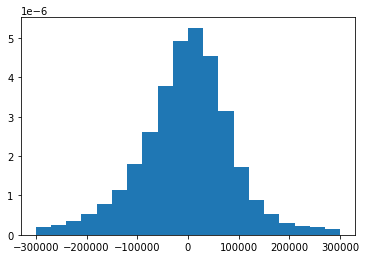

time: 202 ms (started: 2021-06-03 17:15:50 -08:00)


In [84]:
fig, ax = plt.subplots()
ax.hist(residual, bins=20, density=True, range =[-300000,300000]);
plt.savefig('Visualizations/residuals_hist')

Based on the plot above, it looks like the residuals are normally distributed around 0, this is a good sign 


/Users/kyledufrane/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


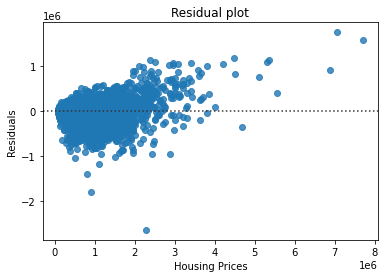

time: 261 ms (started: 2021-06-03 17:15:50 -08:00)


In [85]:
sns.residplot(y, residual)
    
plt.xlabel("Housing Prices")
plt.ylabel("Residuals")
plt.title('Residual plot');
plt.savefig('Visualizations/residuals')

There appears to be some slight heteroskedasticity in the plot above, due to some outliers in the upper right portion of the graph.

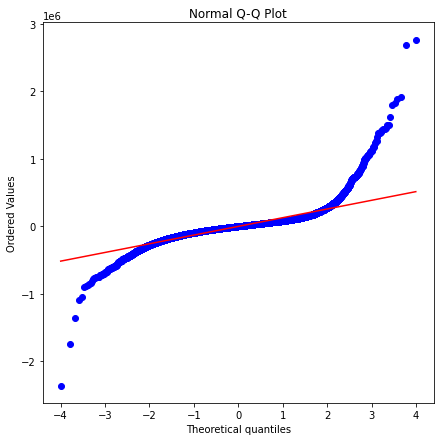

time: 255 ms (started: 2021-06-03 17:15:50 -08:00)


In [86]:
plt.figure(figsize=(7,7))
stats.probplot(residual, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.savefig('Visualizations/residuals')

Let's also run a quick train/test split to make sure we are not overfitting out data

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
print(len(X_train), len(X_test), len(y_train), len(y_test))

lr = LinearRegression()
lr.fit(X_train, y_train)
train_score = round(lr.score(X_train, y_train),3)
test_score = round(lr.score(X_test, y_test), 3)

print("train r-squared: {}".format(train_score) + " test r-squared: {}".format(test_score))

15117 6480 15117 6480
train r-squared: 0.842 test r-squared: 0.841
time: 49.9 ms (started: 2021-06-03 17:15:50 -08:00)


#### Model implications for our stakeholder

In [88]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])

time: 649 µs (started: 2021-06-03 17:15:50 -08:00)


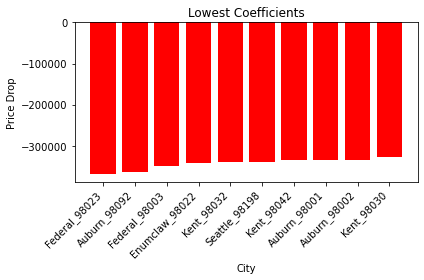

time: 272 ms (started: 2021-06-03 17:15:50 -08:00)


In [89]:
cdf_cities = cdf.iloc[25:,:]
negative_cities = cdf_cities.sort_values(by='Coefficients')
y_negative_cities = list(negative_cities['Coefficients'].values[0:10])
x_negative_cities = list(negative_cities['Coefficients'].index[0:10])

plt.bar(x_negative_cities, y_negative_cities, color='red')
plt.title('Lowest Coefficients')
plt.xlabel('City')
plt.ylabel('Price Drop')
plt.xticks(rotation=45, ha='right');
plt.tight_layout()
plt.savefig('Visualizations/Negative Coefficients')

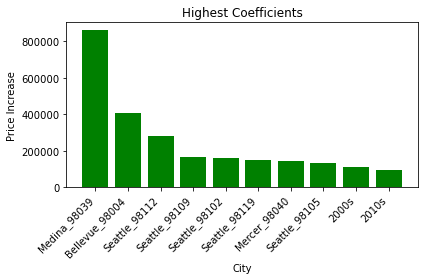

time: 196 ms (started: 2021-06-03 17:15:51 -08:00)


In [90]:
positive_cities = cdf_cities.sort_values(by='Coefficients', ascending=False)
positive_cities

y_positive_cities = list(positive_cities['Coefficients'].values[0:10])
x_positive_cities = list(positive_cities['Coefficients'].index[0:10])

plt.bar(x_positive_cities, y_positive_cities, color='green')
plt.title('Highest Coefficients')
plt.xlabel('City')
plt.ylabel('Price Increase')
plt.xticks(rotation=45, ha='right');
plt.tight_layout()
plt.savefig('Visualizations/Positive Coefficients')

In [91]:
cdf_cities

,Coefficients
Auburn_98001,-335048.996725
Auburn_98002,-334986.564971
Auburn_98092,-364621.281197
Bellevue_98004,406959.319897
Bellevue_98005,-32109.791503
...,...
1990s,51459.275523
2000s,111386.326548
2010s,92909.033694
No remodel,-2864.981202


time: 4.79 ms (started: 2021-06-03 17:15:51 -08:00)


In [92]:
# good_school_districts = ['Issaquah', 'Vashon', 'Auburn', 'Enumclaw', 'Renton', 'Lakewood', 'Mercer Island', 'Highline']

time: 171 µs (started: 2021-06-03 17:15:51 -08:00)


In [93]:
# school_prices = []
# for index, value in enumerate(good_school_districts):
#     index = X.copy()
#     index['bedrooms'] = index['bedrooms'].apply(lambda x: 4)
#     index['bedrooms'] = index['bathrooms'].apply(lambda x: 5)
#     index = index[index[value] == 1]
#     preds = model.predict(index)
#     pred_mean = np.mean(preds)
#     school_prices.append(pred_mean)


time: 185 µs (started: 2021-06-03 17:15:51 -08:00)


In [94]:
# school_prices

time: 167 µs (started: 2021-06-03 17:15:51 -08:00)


In [95]:
# plt.bar(good_school_districts, school_prices)
# plt.title('Mean Predicted Price of 4 Bedroom / 5 Bathroom Home')
# plt.xlabel('School District')
# plt.ylabel('Mean Predicted Price (in $mm)')
# plt.xticks(rotation=45, ha='right');
# plt.tight_layout()
# plt.savefig('Visualizations/housing_preds')

time: 178 µs (started: 2021-06-03 17:15:51 -08:00)


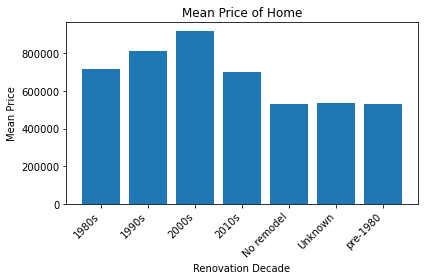

time: 170 ms (started: 2021-06-03 17:15:51 -08:00)


In [96]:
df_yr_renovated = df.groupby('yr_renovated').mean().reset_index()
plt.bar(df_yr_renovated['yr_renovated'], df_yr_renovated['price'])
plt.title('Mean Price of Home')
plt.xlabel('Renovation Decade')
plt.ylabel('Mean Price')
plt.xticks(rotation=45, ha='right');
plt.tight_layout()
plt.savefig('Visualizations/remodeling')

In [97]:
good_school_districts = ['Issaquah', 'Vashon', 'Auburn', 'Enumclaw', 'Renton', 'Lakewood', 'Mercer Island', 'Highline']

time: 270 µs (started: 2021-06-03 17:15:51 -08:00)


In [98]:
schools_df = df[df['Neighborhood'].isin(good_school_districts)]

time: 2.21 ms (started: 2021-06-03 17:15:51 -08:00)


In [99]:
x = schools_df.groupby('Neighborhood').mean()['price'].index
y = (schools_df.groupby('Neighborhood').mean()['price'].values / 1000000)

time: 4.69 ms (started: 2021-06-03 17:15:51 -08:00)


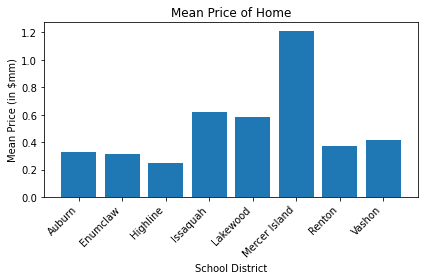

time: 189 ms (started: 2021-06-03 17:15:51 -08:00)


In [100]:
plt.bar(x, y)
plt.title('Mean Price of Home')
plt.xlabel('School District')
plt.ylabel('Mean Price (in $mm)')
plt.xticks(rotation=45, ha='right');
plt.tight_layout()
plt.savefig('Visualizations/school_disctrict')

In [101]:
df_folium = pd.read_csv('data/KC_with_hoods', index_col=0)
relevant_cols = ['lat', 'long']
df_folium = df_folium[relevant_cols]
stakeholder_df = df.copy()

time: 47.5 ms (started: 2021-06-03 17:15:51 -08:00)


In [102]:
stakeholder_df = pd.concat([stakeholder_df.reset_index(drop=True), df_folium.reset_index(drop=True)], axis=1)

time: 8 ms (started: 2021-06-03 17:15:51 -08:00)


In [103]:
stakeholder_df['Neighborhood'] = stakeholder_df['Neighborhood'].replace(to_replace='Other', value="N/A")

time: 2.87 ms (started: 2021-06-03 17:15:51 -08:00)


In [104]:
stakeholder_df['Neighborhood'].value_counts()

N/A                3304
Sammamish           886
Kirkland            701
Kent                566
Redmond             496
                   ... 
Coal Creek           12
Eastwood Forest      12
Endolyne             11
Wyngates             11
Willow Ridge         11
Name: Neighborhood, Length: 251, dtype: int64

time: 6.08 ms (started: 2021-06-03 17:15:51 -08:00)


In [105]:
stakeholder_df = stakeholder_df[stakeholder_df['bedrooms'] == 4]
stakeholder_df = stakeholder_df[stakeholder_df['sqft_living'] >= 4750]

time: 10.5 ms (started: 2021-06-03 17:15:51 -08:00)


In [106]:
stakeholder_df

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,...,Neighborhood,Yr_sold,Mo_sold,sqft_grade,City,Zip_city,prediction,residual,lat,long
5,1230000.0,4,4.50,5420,1.0,0.0,0.0,3,11,1530.0,...,N/A,0.0,5,59620,Redmond,Redmond_98053,1.647967e+06,-417966.949757,47.6561,-122.005
153,2250000.0,4,3.25,5180,2.0,0.0,3.0,3,12,1640.0,...,Somerset,1.0,4,62160,Bellevue,Bellevue_98006,1.908059e+06,341940.917506,47.5620,-122.162
269,2900000.0,4,3.25,5050,1.5,0.0,2.0,3,11,300.0,...,N/A,1.0,5,55550,Bellevue,Bellevue_98004,2.234555e+06,665445.234930,47.6312,-122.223
270,1370000.0,4,4.75,5310,2.0,0.0,0.0,4,11,0.0,...,Cottage Lake,0.0,10,58410,Woodinville,Woodinville_98077,1.605873e+06,-235872.846619,47.7285,-122.042
484,1390000.0,4,3.25,4860,2.5,0.0,0.0,3,9,0.0,...,N/A,1.0,4,43740,Sammamish,Sammamish_98074,1.141886e+06,248113.635219,47.6179,-122.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21294,2350000.0,4,4.25,5010,2.0,0.0,1.0,3,11,1010.0,...,Mercer Island,0.0,7,55110,Mercer,Mercer_98040,1.832627e+06,517372.901894,47.5455,-122.211
21317,2000000.0,4,3.25,5640,2.0,0.0,2.0,3,11,740.0,...,N/A,1.0,5,62040,Bellevue,Bellevue_98006,1.875274e+06,124726.230906,47.5491,-122.104
21504,1410000.0,4,4.00,4920,2.0,0.0,0.0,3,10,640.0,...,N/A,0.0,8,49200,Redmond,Redmond_98053,1.339926e+06,70073.784074,47.6575,-122.006
21514,3000000.0,4,3.75,5090,1.0,0.0,0.0,3,11,910.0,...,Clyde,1.0,4,55990,Bellevue,Bellevue_98004,2.102912e+06,897088.098441,47.6200,-122.207


time: 35.3 ms (started: 2021-06-03 17:15:51 -08:00)


In [107]:
 def pricecolors(price):
    if  price <= 750000 and price > 0:
        return 'green'
    elif price <= 1500000 and price > 750000:
        return 'blue'
    elif price <= 2250000 and price > 1500000:
        return 'orange'
    else:
        return 'red'

stakeholder_df['color'] = stakeholder_df['price']
stakeholder_df['color'] = stakeholder_df["color"].apply(pricecolors)
stakeholder_df['color'].value_counts()

blue      50
orange    34
red       29
green      4
Name: color, dtype: int64

time: 5.68 ms (started: 2021-06-03 17:15:51 -08:00)


In [108]:
stakeholder_df

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,...,Yr_sold,Mo_sold,sqft_grade,City,Zip_city,prediction,residual,lat,long,color
5,1230000.0,4,4.50,5420,1.0,0.0,0.0,3,11,1530.0,...,0.0,5,59620,Redmond,Redmond_98053,1.647967e+06,-417966.949757,47.6561,-122.005,blue
153,2250000.0,4,3.25,5180,2.0,0.0,3.0,3,12,1640.0,...,1.0,4,62160,Bellevue,Bellevue_98006,1.908059e+06,341940.917506,47.5620,-122.162,orange
269,2900000.0,4,3.25,5050,1.5,0.0,2.0,3,11,300.0,...,1.0,5,55550,Bellevue,Bellevue_98004,2.234555e+06,665445.234930,47.6312,-122.223,red
270,1370000.0,4,4.75,5310,2.0,0.0,0.0,4,11,0.0,...,0.0,10,58410,Woodinville,Woodinville_98077,1.605873e+06,-235872.846619,47.7285,-122.042,blue
484,1390000.0,4,3.25,4860,2.5,0.0,0.0,3,9,0.0,...,1.0,4,43740,Sammamish,Sammamish_98074,1.141886e+06,248113.635219,47.6179,-122.005,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21294,2350000.0,4,4.25,5010,2.0,0.0,1.0,3,11,1010.0,...,0.0,7,55110,Mercer,Mercer_98040,1.832627e+06,517372.901894,47.5455,-122.211,red
21317,2000000.0,4,3.25,5640,2.0,0.0,2.0,3,11,740.0,...,1.0,5,62040,Bellevue,Bellevue_98006,1.875274e+06,124726.230906,47.5491,-122.104,orange
21504,1410000.0,4,4.00,4920,2.0,0.0,0.0,3,10,640.0,...,0.0,8,49200,Redmond,Redmond_98053,1.339926e+06,70073.784074,47.6575,-122.006,blue
21514,3000000.0,4,3.75,5090,1.0,0.0,0.0,3,11,910.0,...,1.0,4,55990,Bellevue,Bellevue_98004,2.102912e+06,897088.098441,47.6200,-122.207,red


time: 35.1 ms (started: 2021-06-03 17:15:51 -08:00)


In [109]:
import folium


lat = 47.60335
long = -122.1685

base_map = folium.Map([lat,long], zoom_start=11)
base_map

for indice, row in stakeholder_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=('Price: {:.2f}, Square Feet: {}, Neighborhood: {} \
        Predicted Price: {:.2f}'.format(row['price'], row['sqft_living'], row['Neighborhood'], row['prediction'])),
        icon=folium.map.Icon(color=row['color'])
    ).add_to(base_map)
base_map

time: 194 ms (started: 2021-06-03 17:15:51 -08:00)


In [110]:
# We import the geoJSON file.

# We read the file and print it.
geoJSON_df = gpd.read_file('data/Zip_Codes.geojson')
geoJSON_df

DriverError: data/Zip_Codes.geojson: No such file or directory

time: 298 ms (started: 2021-06-03 17:15:52 -08:00)


In [111]:
selected_zips = df.groupby('zipcode').mean()['price'].index

time: 6.61 ms (started: 2021-06-03 17:16:01 -08:00)


In [112]:
new_df = geoJSON_df[geoJSON_df['ZIP'].isin(selected_zips)]

NameError: name 'geoJSON_df' is not defined

time: 8.29 ms (started: 2021-06-03 17:16:02 -08:00)


In [113]:
new_df

NameError: name 'new_df' is not defined

time: 5.9 ms (started: 2021-06-03 17:16:02 -08:00)


In [114]:
new_df = new_df.sort_values(by='ZIP')

NameError: name 'new_df' is not defined

time: 6.21 ms (started: 2021-06-03 17:16:02 -08:00)


In [115]:
new_df = new_df.drop_duplicates(subset='ZIPCODE', keep='first')

NameError: name 'new_df' is not defined

time: 6.82 ms (started: 2021-06-03 17:16:02 -08:00)


In [116]:
new_df['ZIP'].value_counts()

NameError: name 'new_df' is not defined

time: 6.1 ms (started: 2021-06-03 17:16:02 -08:00)


In [117]:
new_df

NameError: name 'new_df' is not defined

time: 6.18 ms (started: 2021-06-03 17:16:02 -08:00)


In [ ]:
mean_price_values = df.groupby('zipcode').mean()['price'].values

In [ ]:
new_df['price'] = mean_price_values

In [ ]:
new_df

In [ ]:
cities_coefs = cdf_cities.iloc[0:69,:]
cities_coefs.index.name = 'zipcode'
cities_coefs = cities_coefs.reset_index()

In [ ]:
cities_coefs['zipcode'] = cities_coefs['zipcode'].apply(lambda x: x[-5:])

In [ ]:
cities_coefs['test'] = 0

In [ ]:
cities_coefs

In [ ]:
def map_coefs(zipcode):
    for row in cities_coefs.index:
        if zipcode == cities_coefs['zipcode'][row]:
            return cities_coefs['Coefficients'][row]
        
cities_coefs['test'] = cities_coefs['zipcode'].apply(map_coefs)

In [ ]:
cities_coefs

In [ ]:
new_df['coefs'] = new_df['ZIPCODE'].apply(map_coefs)

In [ ]:
new_df['City'] = new_df['ZIP'].apply(map_city)

In [ ]:
new_df['coefs'] = new_df['coefs'].fillna(value=0) # This zip was the dummy so we don't have the coefficient 

In [ ]:
old_df = pd.read_csv('data/KC_with_hoods', index_col=0)

In [ ]:
df['lat'] = old_df['lat']
df['long'] = old_df['long']

In [ ]:
lats = df.groupby('zipcode').median()['lat'].values
longs = df.groupby('zipcode').median()['long'].values

In [ ]:
new_df['lat'] = lats
new_df['long'] = longs

In [ ]:
new_df['coefs'] = new_df['coefs'].apply(lambda x: float(x) )

In [ ]:
 def coefcolors(coef):
    if  coef < 0:
        return 'green'
    else:
        return 'red'

new_df['color'] = new_df['coefs']

In [ ]:
new_df['color'] = new_df['color'].apply(coefcolors)

In [ ]:
new_df

In [ ]:
lat = 47.60335
long = -122.1685

choro_map = folium.Map([lat,long], zoom_start=11)
choro_map


folium.Choropleth(
    geo_data=new_df,
    data=new_df,
    columns=['ZIP','price'],
    key_on='feature.properties.ZIP',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price per home').add_to(choro_map)
choro_map

for indice, row in new_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=('City: {}, Coefficient: {:.2f}, Avg Price: {:.2f}\
        '.format(row['City'], row['coefs'], row['price'])),
        icon=folium.map.Icon(color=row['color'])
    ).add_to(choro_map)
choro_map